In [1]:
import pandas as pd

df = pd.read_csv("dataset_mood_smartphone.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376912 entries, 0 to 376911
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  376912 non-null  int64  
 1   id          376912 non-null  object 
 2   time        376912 non-null  object 
 3   variable    376912 non-null  object 
 4   value       376710 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 14.4+ MB


In [2]:
def clean_dataset(df: pd.DataFrame) -> pd.DataFrame:
    
    df = df.drop("Unnamed: 0", axis=1)
    df['time'] = pd.to_datetime(df["time"])
    
    var_names = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen',
                 'call', 'sms', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment',
                 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
                 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

    user_ids = ['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', 'AS14.07', 'AS14.08',
           'AS14.09', 'AS14.12', 'AS14.13', 'AS14.14', 'AS14.15', 'AS14.16', 'AS14.17',
           'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24', 'AS14.25', 'AS14.26', 'AS14.27',
           'AS14.28', 'AS14.29', 'AS14.30', 'AS14.31', 'AS14.32', 'AS14.33']


    # helper to concat dfs grouped by var name
    df_out = pd.DataFrame()

    # group by variable type
    for name in var_names:
        df_var_tmp = df[df['variable'] == name]

        # helper to concat dfs grouped by id
        df_var = pd.DataFrame()

        # group by user id
        for id in user_ids:
            df_id_tmp = df_var_tmp[df_var_tmp['id'] == id]

            # remove missing values
            df_id_tmp = df_id_tmp[df_id_tmp['value'].notna()]

            # drop values outside the range

            # 1 to 10
            if name == "mood":
                df_id_tmp = df_id_tmp[(df_id_tmp['value'] >= 1) & (df_id_tmp['value'] <= 10)]
            # 0 to 1
            elif name == "activity":
                df_id_tmp = df_id_tmp[(df_id_tmp['value'] >= 0) & (df_id_tmp['value'] <= 1)]
            # -2 to 2
            elif name in ['circumplex.arousal', 'circumplex.valence']:
                df_id_tmp = df_id_tmp[(df_id_tmp['value'] >= -2) & (df_id_tmp['value'] <= 2)]
            # 1
            elif name in ['sms', 'call']:
                df_id_tmp = df_id_tmp[df_id_tmp['value'] == 1]
            # else is time data, so > 0
            else:
                df_id_tmp = df_id_tmp[df_id_tmp['value'] >= 0]

            # remove outliers bellow 01 quantile and above 99 quantile
            lower = df_id_tmp['value'].quantile(.01)
            upper = df_id_tmp['value'].quantile(.99)

            # outliers replaced with lower and upper value respectively
            df_id_tmp['value'] = df_id_tmp['value'].clip(lower=lower, upper=upper)

            # drop duplicates with the exact same date by taking a mean of them
            df_id_tmp = df_id_tmp.groupby([df_id_tmp['id'], df_id_tmp['time'], df_id_tmp['variable']])['value'].mean().reset_index()

            # grouping by day
            if name in ['mood', 'circumplex.arousal', 'circumplex.valence']:
                df_id_tmp = df_id_tmp.groupby([df_id_tmp['id'], df_id_tmp['time'].dt.date, df_id_tmp['variable']])['value'].mean().reset_index()
            else:
                df_id_tmp = df_id_tmp.groupby([df_id_tmp['id'], df_id_tmp['time'].dt.date, df_id_tmp['variable']])['value'].sum().reset_index()

            # concat df
            df_var = pd.concat([df_var, df_id_tmp])

        # concat df
        df_out = pd.concat([df_out, df_var])
    
    df_out.sort_values(by = ['id', 'time'], inplace=True)
    
    df_out.reset_index(drop=True, inplace=True)
    
    return df_out

df_clean = clean_dataset(df)
df_clean.head()

,id,time,variable,value
0,AS14.01,2014-02-17,call,2.0
1,AS14.01,2014-02-18,call,1.0
2,AS14.01,2014-02-19,call,7.0
3,AS14.01,2014-02-19,sms,2.0
4,AS14.01,2014-02-20,call,2.0


In [3]:
def pivot_to_wide(df: pd.DataFrame) -> pd.DataFrame:
    return pd.pivot(df, index=['id','time'], columns='variable', values = 'value').reset_index()
    
wide = pivot_to_wide(df_clean)
wide.head()

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,AS14.01,2014-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
1,AS14.01,2014-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,AS14.01,2014-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,2.0
3,AS14.01,2014-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,3.0
4,AS14.01,2014-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## Fill in the NaN values for each column

Filling zeroes to the variables starting with appCat, activity, call and sms have the following meaning:
- appCat: zero time spent on this appCat
- activity: zero time spent on the phone
- call: zero calls have been done
- sms: zero SMSs have been sent
    
Assign mean values to the following variables "circumplex.arousal", "circumplex.valence", "mood" because we have no baseline to compare to, as to say, for the starting values. My assigning these values to the mean we would be unbiased towards any side.

In [4]:
# Save df with these variables
contains_zeroes = ["circumplex.arousal", "circumplex.valence", "mood"]
partial_df = wide[contains_zeroes]

# Fill NaN values with mean values
partial_df = partial_df.fillna(value=partial_df.mean())

# Fill NaN values with zeroes
dropped_df = wide.drop(contains_zeroes, axis=1).fillna(0)
merged_df = pd.merge(dropped_df, partial_df, left_index=True, right_index=True)

merged_df

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,circumplex.arousal,circumplex.valence,mood
0,AS14.01,2014-02-17,0.000000,0.00000,0.00000,0.000,0.0,0.0,0.00000,0.0000,...,0.000,0.00000,0.00000,0.0,2.0,0.000000,0.0,-0.104289,0.68739,6.9934
1,AS14.01,2014-02-18,0.000000,0.00000,0.00000,0.000,0.0,0.0,0.00000,0.0000,...,0.000,0.00000,0.00000,0.0,1.0,0.000000,0.0,-0.104289,0.68739,6.9934
2,AS14.01,2014-02-19,0.000000,0.00000,0.00000,0.000,0.0,0.0,0.00000,0.0000,...,0.000,0.00000,0.00000,0.0,7.0,0.000000,2.0,-0.104289,0.68739,6.9934
3,AS14.01,2014-02-20,0.000000,0.00000,0.00000,0.000,0.0,0.0,0.00000,0.0000,...,0.000,0.00000,0.00000,0.0,2.0,0.000000,3.0,-0.104289,0.68739,6.9934
4,AS14.01,2014-02-21,0.000000,0.00000,0.00000,0.000,0.0,0.0,0.00000,0.0000,...,0.000,0.00000,0.00000,0.0,0.0,0.000000,1.0,-0.104289,0.68739,6.9934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,AS14.33,2014-05-27,0.304902,555.85736,2078.40300,124.694,0.0,0.0,0.00000,142.6860,...,0.000,0.00000,56.17400,0.0,1.0,4089.879001,2.0,-0.600000,0.40000,6.2000
1969,AS14.33,2014-05-28,2.479228,2310.27220,1936.88728,614.706,0.0,0.0,351.86132,519.0175,...,0.000,0.00000,30.66600,0.0,10.0,12718.706198,1.0,0.000000,1.20000,8.2000
1970,AS14.33,2014-05-29,4.064507,400.03400,435.10500,136.738,0.0,0.0,0.00000,29.2020,...,0.939,0.00000,3.19900,0.0,5.0,3440.799000,1.0,-1.333333,1.00000,7.0000
1971,AS14.33,2014-05-30,4.041369,2566.80988,1670.84200,260.220,0.0,0.0,0.00000,52.6100,...,1052.648,8.13206,213.73936,0.0,4.0,9497.646999,0.0,-0.800000,-0.40000,6.8000


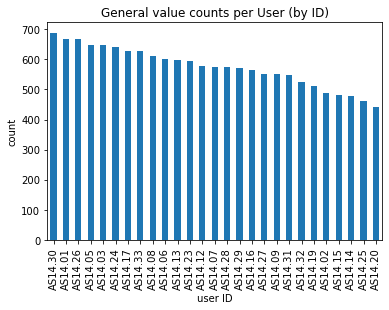

In [5]:
import matplotlib.pyplot as plt
df_clean.id.value_counts().plot(kind="bar")
plt.title("General value counts per User (by ID)")
plt.xlabel("user ID")
plt.ylabel("count")
plt.show()

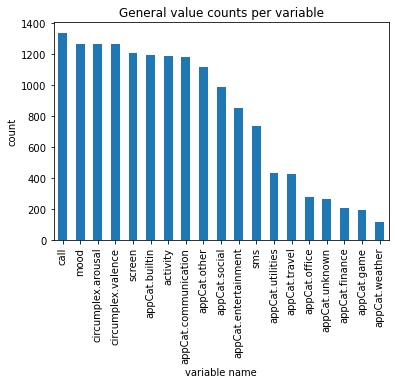

In [6]:
df_clean.variable.value_counts().plot(kind="bar")
plt.title("General value counts per variable")
plt.xlabel("variable name")
plt.ylabel("count")
plt.show()

#### Plot timeseries function

can be used to plot all of the time series scatter plots at once
- y axis: values of a given variable
- x axis: time

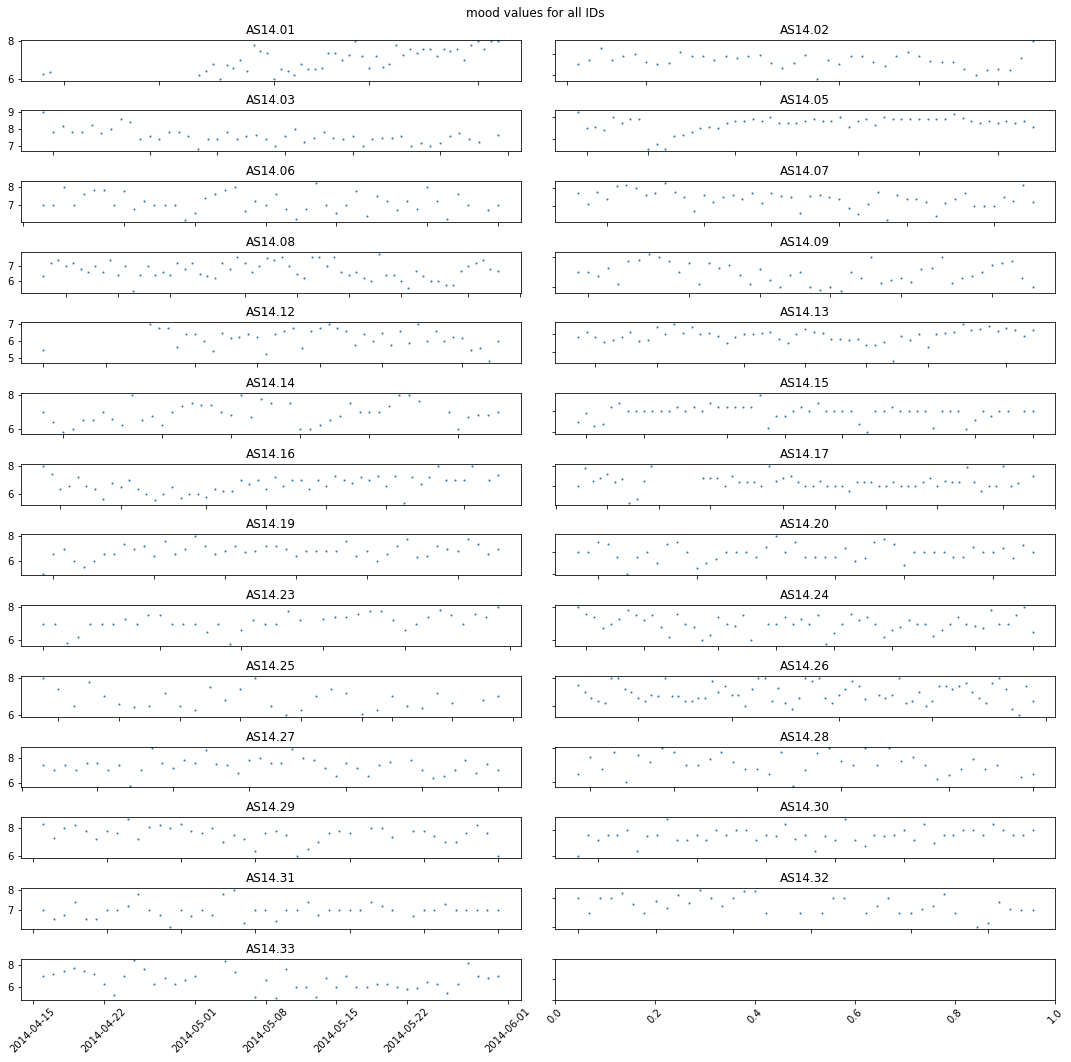

In [7]:
def plot_timeseries(df: pd.DataFrame, variable: str) -> None:
    df = df[df['variable'] == variable]
    id_data = []
    for id in df['id'].unique():
        id_df = df[df['id'] == id]
        id_data.append((id_df['time'], id_df['value'], id))
        
    vertical_axs = 14 # because we have 27 ids in total, 2 per row
    fig, axs = plt.subplots(vertical_axs, 2)
    
    for x in range(vertical_axs):
        id_1 = 2*x
        id_2 = id_1 + 1
        
        # left subplot in a row
        if(id_1 < len(id_data)):
            axs[x, 0].plot_date(id_data[id_1][0], id_data[id_1][1], markersize=1)
            axs[x, 0].set_title(id_data[id_1][2])
        
        # right subplot in a row
        if(id_2 < len(id_data)):
            axs[x, 1].plot_date(id_data[id_2][0], id_data[id_2][1], markersize=1)
            axs[x, 1].set_title(id_data[id_2][2])
    
    for ax in fig.get_axes():
        # only outer labels
        ax.label_outer()
        # rotate labels for timeseries data
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
    
    fig.set_figheight(15)
    fig.set_figwidth(15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.suptitle(f"{variable} values for all IDs")
    

plot_timeseries(df_clean, "mood")

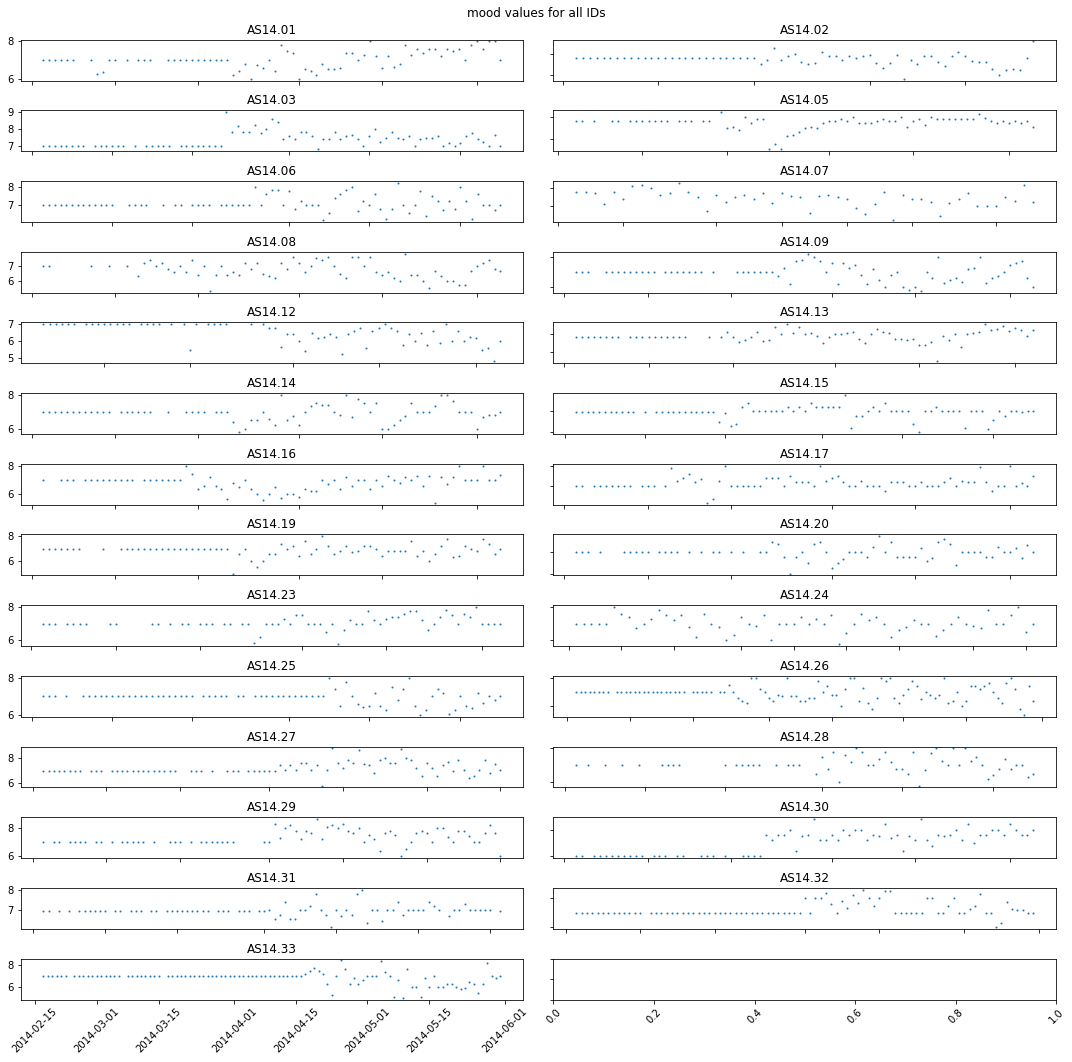

In [8]:
def plot_timeseries_merged(df: pd.DataFrame, variable: str) -> None:
    df = df[["id", "time", variable]]
    id_data = []
    for id in df['id'].unique():
        id_df = df[df['id'] == id]
        id_data.append((id_df['time'], id_df[variable], id))
        
    vertical_axs = 14 # because we have 27 ids in total, 2 per row
    fig, axs = plt.subplots(vertical_axs, 2)
    
    for x in range(vertical_axs):
        id_1 = 2*x
        id_2 = id_1 + 1
        
        # left subplot in a row
        if(id_1 < len(id_data)):
            axs[x, 0].plot_date(id_data[id_1][0], id_data[id_1][1], markersize=1)
            axs[x, 0].set_title(id_data[id_1][2])
        
        # right subplot in a row
        if(id_2 < len(id_data)):
            axs[x, 1].plot_date(id_data[id_2][0], id_data[id_2][1], markersize=1)
            axs[x, 1].set_title(id_data[id_2][2])
    
    for ax in fig.get_axes():
        # only outer labels
        ax.label_outer()
        # rotate labels for timeseries data
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
    
    fig.set_figheight(15)
    fig.set_figwidth(15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.suptitle(f"{variable} values for all IDs")
    

plot_timeseries_merged(merged_df, "mood")

to plot a bigger single plot for a given id

Text(0.5, 1.0, 'AS14.01 mood')

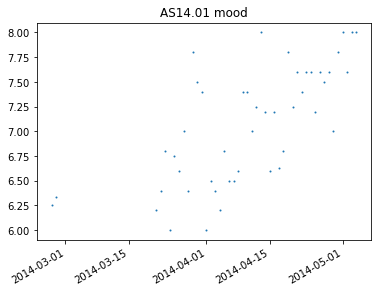

In [9]:
variable = 'mood'
id = 'AS14.01'
df_1 = df_clean[df_clean['variable'] == variable]
df_1 = df_1[df_1['id'] == id]
plt.plot_date(df_1['time'], df_1['value'], markersize=1)
plt.xticks(rotation=30, ha='right')
plt.title(f"{id} {variable}")

In [10]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_clean, title="Report")
profile

ModuleNotFoundError: No module named 'pandas_profiling'

In [11]:
# Normalize the data
normalized_df = merged_df.drop(["id", "time"], axis=1)
normalized_df=(normalized_df-normalized_df.min())/(normalized_df.max()-normalized_df.min())
normalized_df

variable,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,circumplex.arousal,circumplex.valence,mood
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.064516,0.000000,0.000000,0.473928,0.577259,0.665567
1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.032258,0.000000,0.000000,0.473928,0.577259,0.665567
2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.225806,0.000000,0.117647,0.473928,0.577259,0.665567
3,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.064516,0.000000,0.176471,0.473928,0.577259,0.665567
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.058824,0.473928,0.577259,0.665567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,0.026449,0.108410,0.143937,0.014786,0.0,0.0,0.00000,0.039256,0.078828,0.000000,0.000000,0.031242,0.0,0.032258,0.211007,0.117647,0.350000,0.484702,0.533333
1969,0.215064,0.450578,0.134137,0.072893,0.0,0.0,0.07392,0.142791,0.201431,0.000000,0.000000,0.017056,0.0,0.322581,0.656190,0.058824,0.500000,0.742351,0.866667
1970,0.352581,0.078020,0.030133,0.016215,0.0,0.0,0.00000,0.008034,0.070161,0.000356,0.000000,0.001779,0.0,0.161290,0.177519,0.058824,0.166667,0.677939,0.666667
1971,0.350574,0.500611,0.115712,0.030857,0.0,0.0,0.00000,0.014474,0.124116,0.398864,0.003259,0.118875,0.0,0.129032,0.490007,0.000000,0.300000,0.227053,0.633333


We can see from the pairsplot and the correlation matrix that some variables don't have a unique relation with mood. Therefore, we could reduce or combine a couple of, seeming to be redundant, variables in order to still get a feature that might be useful for the predictive model. 

KeyboardInterrupt: 

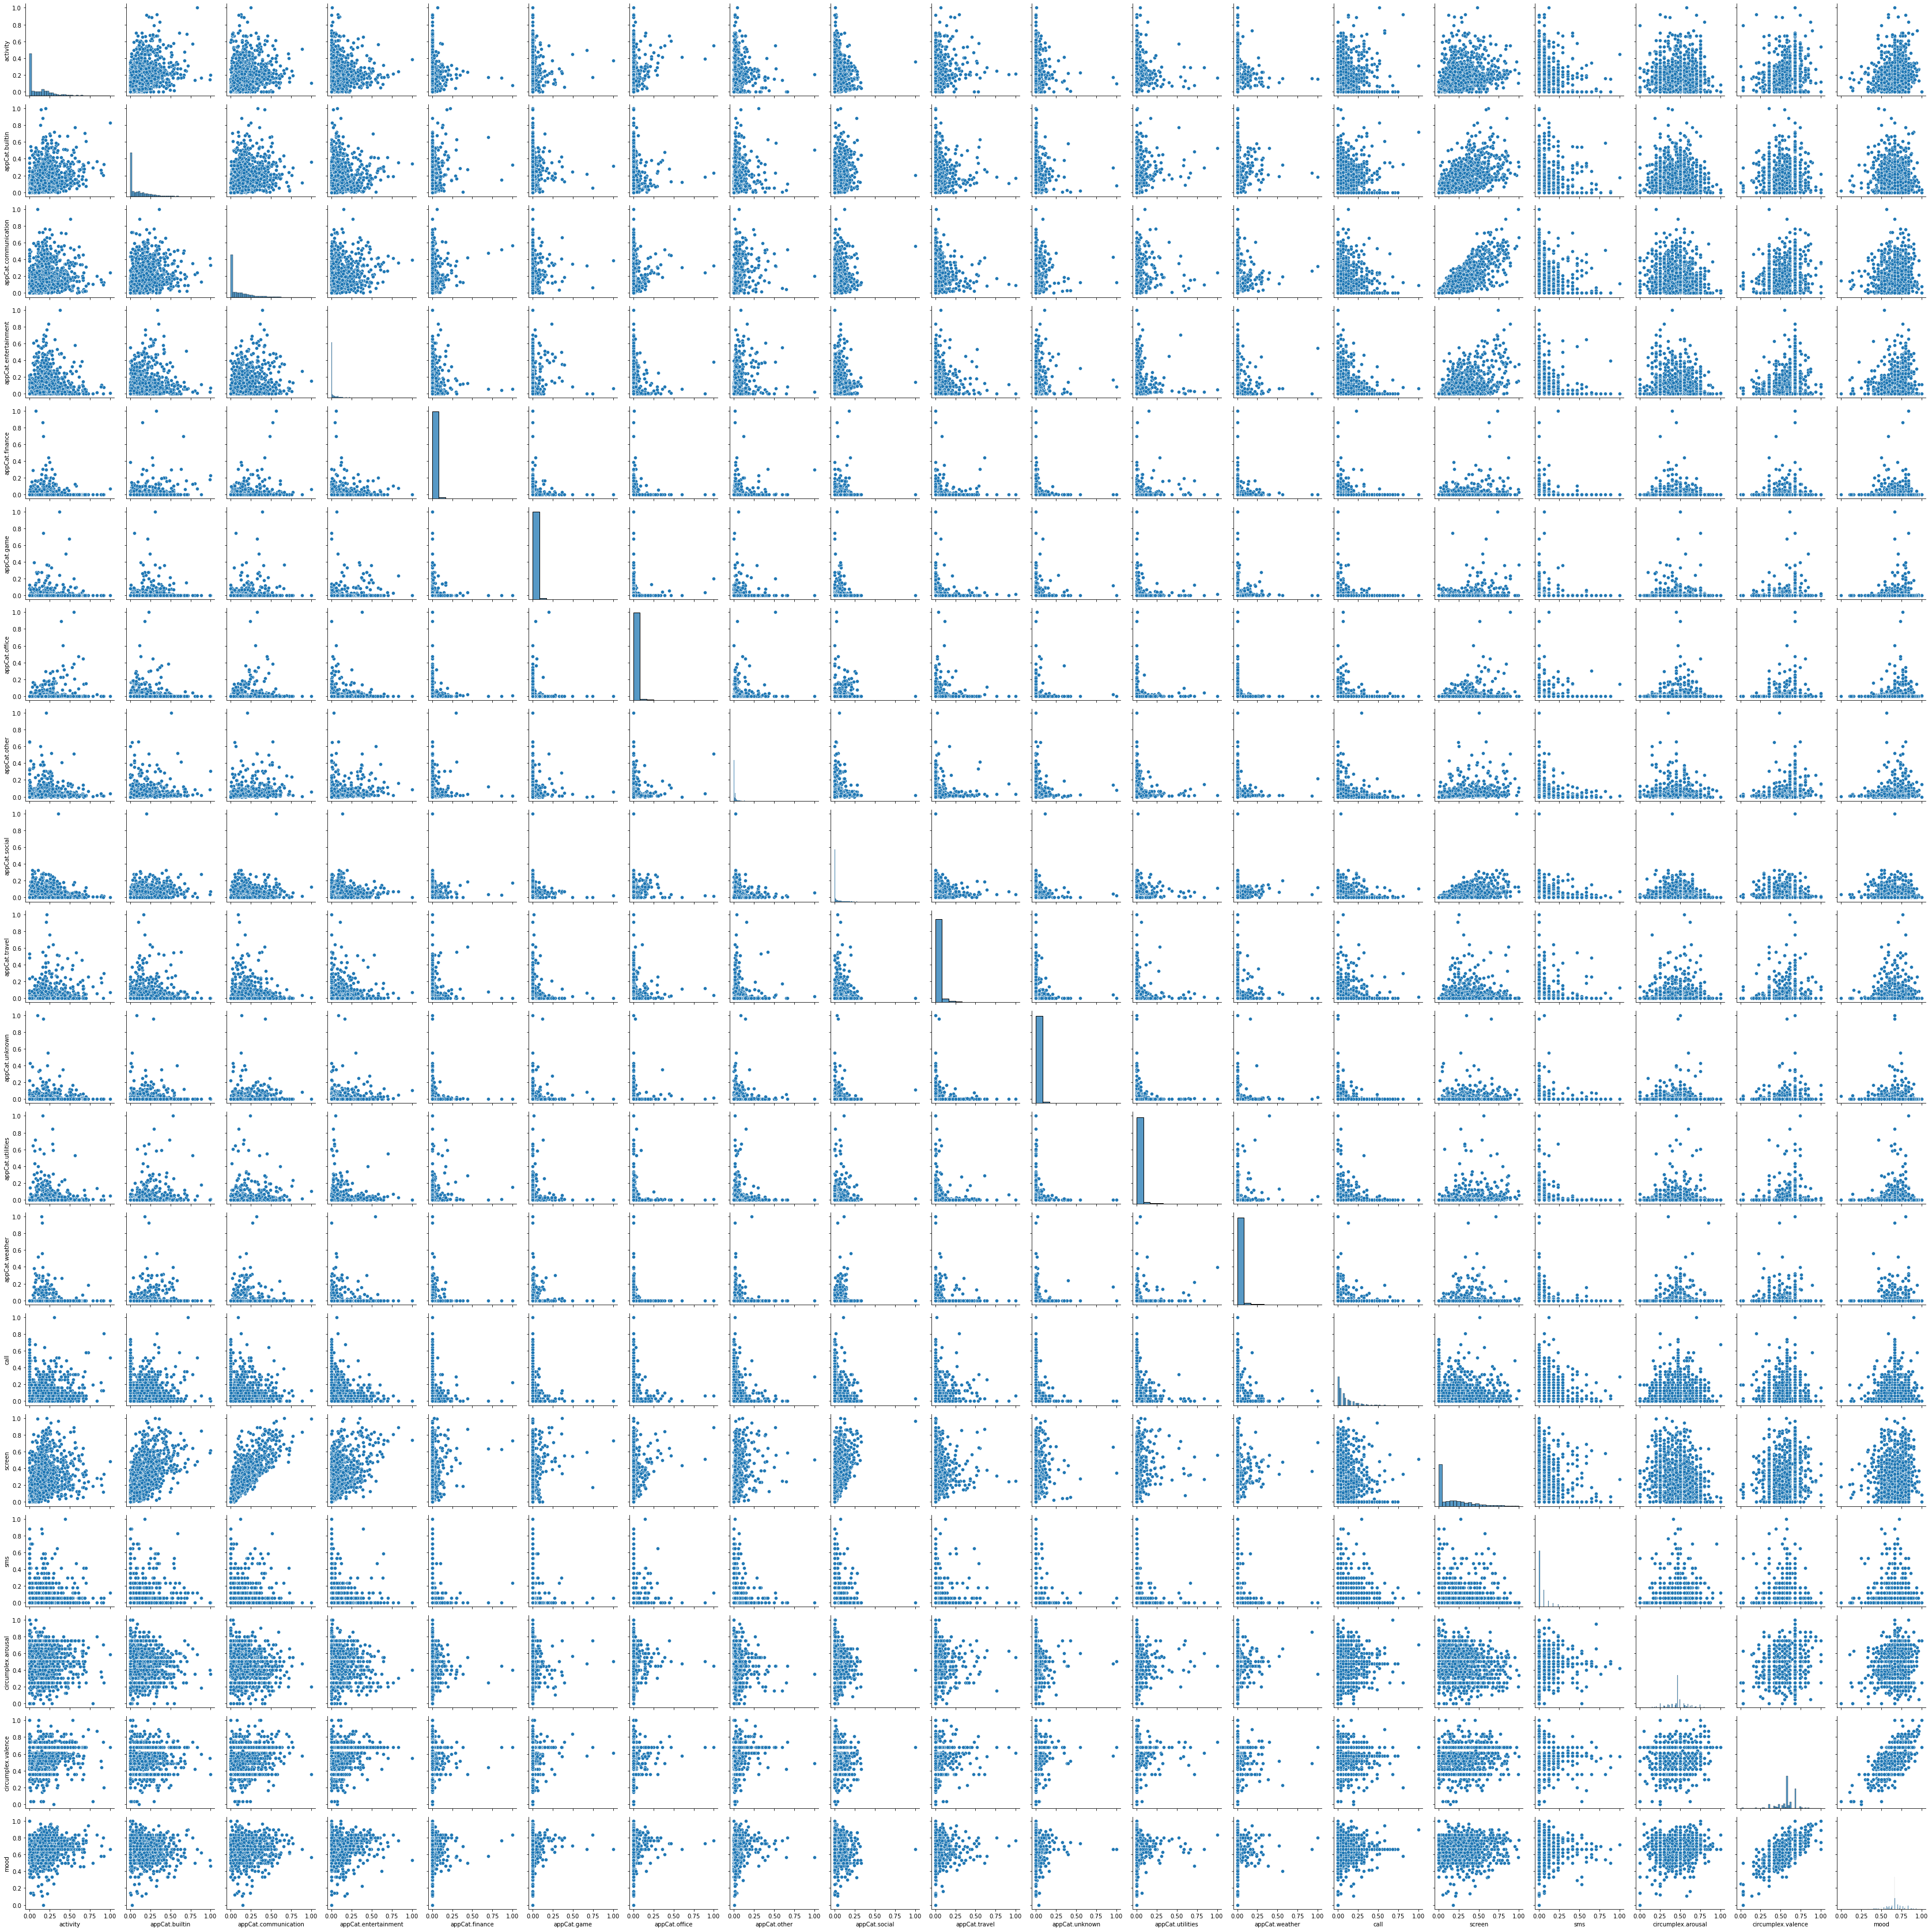

In [12]:
import seaborn as sns
sns.pairplot(normalized_df)
plt.show()

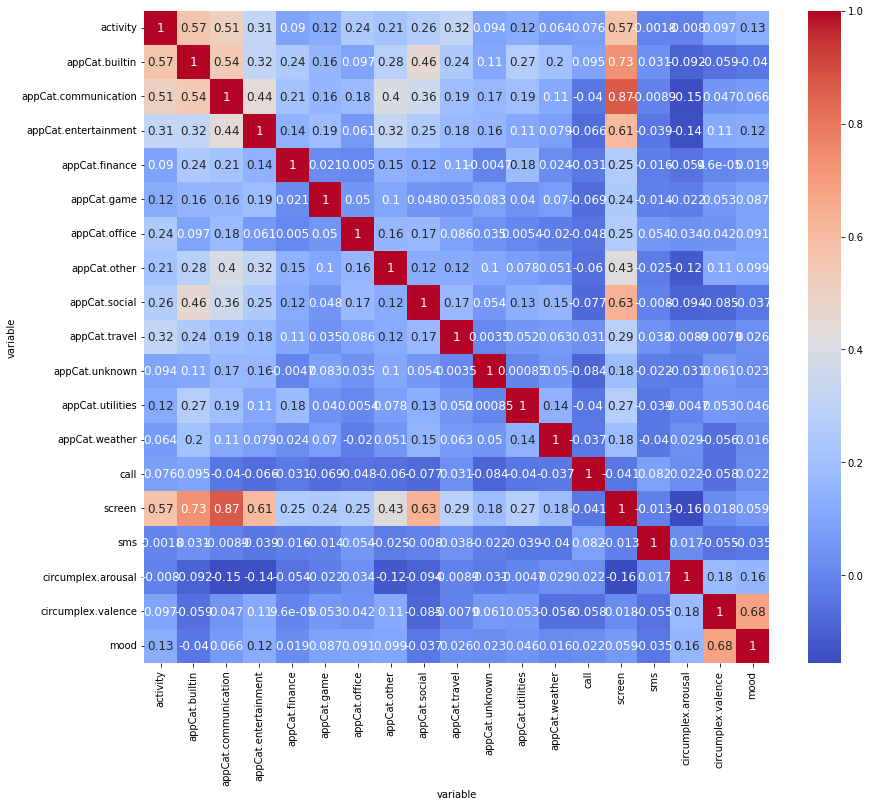

In [13]:
corr_matrix = normalized_df.corr()
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, ax=ax, annot_kws={"size": 12})
plt.show()

In [14]:
from scipy import stats

anovas = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen',
             'call', 'sms', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment',
             'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
             'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

anovas = list(map(lambda x: normalized_df[[x]], anovas))

F, p = stats.f_oneway(*anovas)
F, p

(array([7475.73813469]), array([0.]))

# Feature Engineering

This part explains the feature engineering part of the assignment. We will use the normalized data set to start this process.

In [28]:
wide_norm = pd.concat([merged_df[['id','time']],normalized_df], axis = 1)

In [39]:
delta = wide_norm['time'].max() - wide_norm['time'].min()
delta.days/8

14.0

To include the past mood of a person, we create a feature that calculates the mean of the past k days. The code below calculates the moving average for some k's. This can be automated but it shows the obvious -> the lower the k, the higher the correlation with the mood. This code does not yet account for users

In [46]:
wide_norm['sma2'] = wide_norm['mood'].rolling(window = 2, min_periods = 2).mean()
wide_norm['sma5'] = wide_norm['mood'].rolling(window = 5, min_periods = 5).mean()
wide_norm['sma10'] = wide_norm['mood'].rolling(window = 10, min_periods = 10).mean()
wide_norm['sma15'] = wide_norm['mood'].rolling(window = 15, min_periods = 15).mean()
wide_norm['sma20'] = wide_norm['mood'].rolling(window = 20, min_periods = 20).mean()
wide_norm

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,screen,sms,circumplex.arousal,circumplex.valence,mood,sma5,sma10,sma15,sma20,sma2
0,AS14.01,2014-02-17,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,...,0.000000,0.000000,0.473928,0.577259,0.665567,NaN,NaN,NaN,NaN,NaN
1,AS14.01,2014-02-18,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,...,0.000000,0.000000,0.473928,0.577259,0.665567,NaN,NaN,NaN,NaN,0.665567
2,AS14.01,2014-02-19,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,...,0.000000,0.117647,0.473928,0.577259,0.665567,NaN,NaN,NaN,NaN,0.665567
3,AS14.01,2014-02-20,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,...,0.000000,0.176471,0.473928,0.577259,0.665567,NaN,NaN,NaN,NaN,0.665567
4,AS14.01,2014-02-21,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,...,0.000000,0.058824,0.473928,0.577259,0.665567,0.665567,NaN,NaN,NaN,0.665567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,AS14.33,2014-05-27,0.026449,0.108410,0.143937,0.014786,0.0,0.0,0.00000,0.039256,...,0.211007,0.117647,0.350000,0.484702,0.533333,0.502778,0.504722,0.512407,0.519156,0.466667
1969,AS14.33,2014-05-28,0.215064,0.450578,0.134137,0.072893,0.0,0.0,0.07392,0.142791,...,0.656190,0.058824,0.500000,0.742351,0.866667,0.581667,0.541389,0.547963,0.532489,0.700000
1970,AS14.33,2014-05-29,0.352581,0.078020,0.030133,0.016215,0.0,0.0,0.00000,0.008034,...,0.177519,0.058824,0.166667,0.677939,0.666667,0.601667,0.554722,0.549815,0.549306,0.766667
1971,AS14.33,2014-05-30,0.350574,0.500611,0.115712,0.030857,0.0,0.0,0.00000,0.014474,...,0.490007,0.000000,0.300000,0.227053,0.633333,0.620000,0.563889,0.558704,0.542639,0.650000


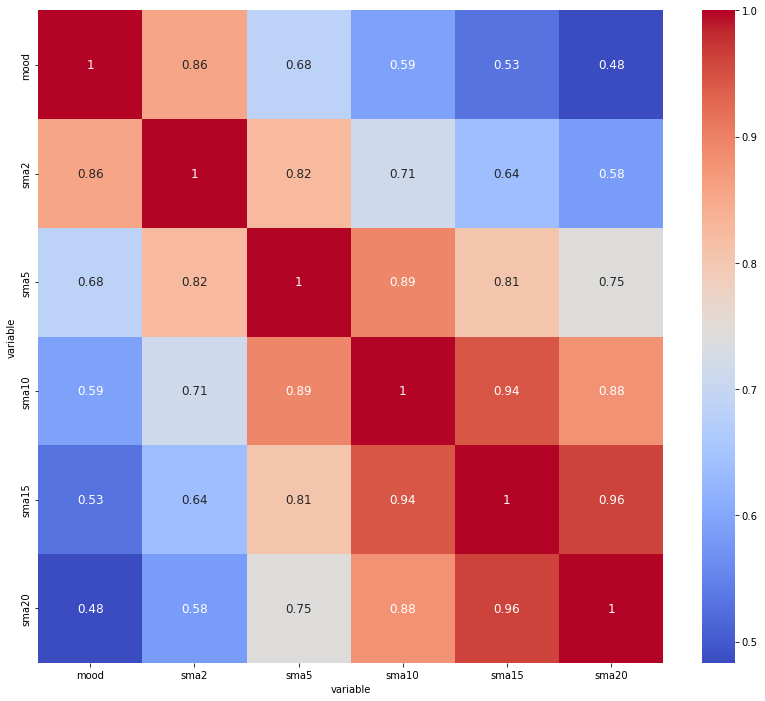

In [47]:
corr_matrix_sma = wide_norm[['mood','sma2','sma5','sma10','sma15','sma20']].corr()
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix_sma, cmap='coolwarm', annot=True, ax=ax, annot_kws={"size": 12})
plt.show()